<a href="https://colab.research.google.com/github/LM1997610/NN/blob/main/NN_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the dataset

In [1]:
! pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
from tqdm import tqdm
from datasets import load_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
dataset = load_dataset(path='Francesco/apex-videogame')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [21]:
for k,v in dataset.items():
  print(f'{k} → {v.num_rows} samples')

train → 2583 samples
validation → 415 samples
test → 691 samples


In [16]:
dataset['train'].features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['apex-game', 'avatar', 'object'], id=None)}, length=-1, id=None)}

In [17]:
class_ids = ['apex-game', 'avatar', 'object']

class_mapping = dict(zip(range(len(class_ids)), class_ids))
print(class_mapping)

{0: 'apex-game', 1: 'avatar', 2: 'object'}


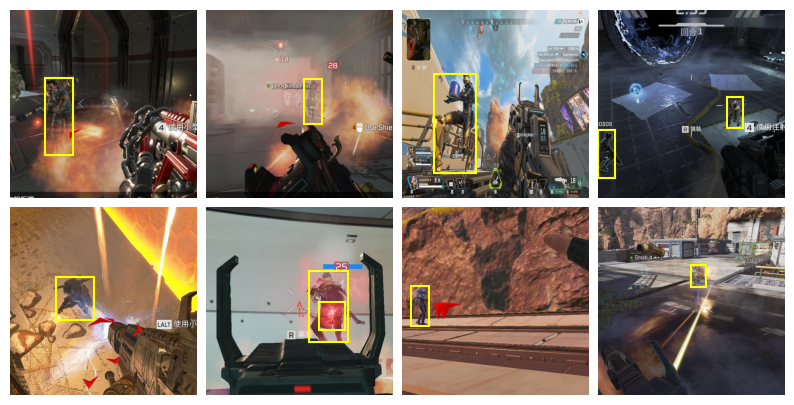

In [58]:
# show sample images from testset and ground true bboxes

images_to_show = [5, 6, 10, 18, 25, 332, 567, 690]

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(dataset['test'][images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  for bbox in dataset['test'][images_to_show[image_n]]['objects']['bbox']:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Load the model

In [31]:
! pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.8 MB/s eta 0:00:00


In [52]:
import os

import keras
import keras_cv

from keras_cv import bounding_box
from keras_cv import visualization

import tensorflow as tf

In [53]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_m_pascalvoc",
                                                              bounding_box_format="xywh")

# pretrained_model.summary()

In [43]:
# inference_resizing = keras_cv.layers.Resizing(640, 640,
#                                               pad_to_aspect_ratio=True,
#                                               bounding_box_format="xywh")

In [59]:
imgs_to_try = [np.array(dataset['test'][i]['image']) for i in images_to_show]

tensor_batch= tf.stack(imgs_to_try)
tensor_batch.shape

TensorShape([8, 640, 640, 3])

In [60]:
y_pred = pretrained_model.predict(tensor_batch)

1/1 [==============================] - 22s 22s/step


In [61]:
def get_bbox_and_confidence(data_pred, index):

  bounding_box = data_pred['boxes'][index]
  filtered_boxes = bounding_box[~np.all(bounding_box == -1, axis=1)]

  confidences = []
  for i in range(len(filtered_boxes)):
    this_conf = data_pred['confidence'][index][i]
    confidences.append(round(this_conf, 4))

  return {'boxes': filtered_boxes, 'confidence': confidences}

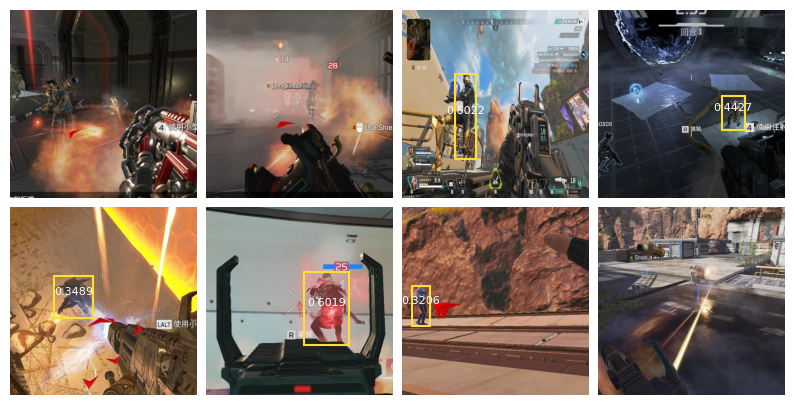

In [62]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(dataset['test'][images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  this_diz = get_bbox_and_confidence(y_pred, image_n)

  for bbox_idx in range(len(this_diz['boxes'])):
    x, y, w, h = this_diz['boxes'][bbox_idx]
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='#FFDD33', facecolor='none')
    ax.add_patch(rect)
    text = this_diz['confidence'][bbox_idx]
    ax.text(x+w/2, y+h/2, text, ha='center', va='bottom', color='white', fontsize=8)


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

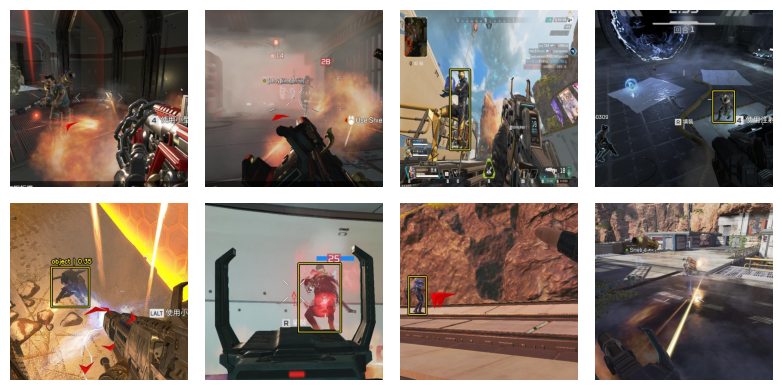

In [63]:
_ = visualization.plot_bounding_box_gallery(tensor_result,
                                            value_range=(0, 255),
                                            rows=2, cols=4,
                                            y_pred=y_pred,
                                            scale=2,
                                            font_scale=0.7,
                                            bounding_box_format="xywh",
                                            class_mapping=class_mapping)


##  Fine-Tuning

In [22]:
all_boxes = []
all_classes = []
all_images = []

for i in tqdm(range(len(train_data))):
  if len(train_data[i]['objects']['bbox']) == 1:
    all_boxes.append(train_data[i]['objects']['bbox'])
    all_classes.append(train_data[i]['objects']['category'])
    resized_image = train_data[i]['image'].resize((256, 256))
    all_images.append(np.array(resized_image))


100%|██████████| 700/700 [00:09<00:00, 76.76it/s]


In [23]:
labels = {"boxes": tf.constant(all_boxes, dtype = tf.float32),
          "classes": tf.constant(all_classes, dtype = tf.int64)}

In [24]:
tensore_unificato = tf.stack([arr for arr in all_images])
print(tensore_unificato.shape)

(567, 256, 256, 3)


In [93]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco", load_weights=False)

prediction_decoder = keras_cv.layers.NonMaxSuppression(bounding_box_format="xywh",
                                                       from_logits=True,
                                                       iou_threshold=0.99,
                                                       confidence_threshold=0.63)

model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                       bounding_box_format="xywh",
                                       backbone=backbone,
                                       prediction_decoder=prediction_decoder,
                                       fpn_depth=1)

In [59]:
# model.summary()

In [97]:
base_lr = 0.005

optimizer = keras.optimizers.SGD(learning_rate=base_lr,
                                 momentum=0.9,
                                 global_clipnorm=10.0)

model.compile(classification_loss="binary_crossentropy",
              box_loss="ciou",
              optimizer=optimizer)

In [98]:
model.fit(x = tensore_unificato, y = labels, epochs=10)

Epoch 1/10
18/18 [==============================] - 57s 923ms/step - loss: 1214.3674 - box_loss: 4.6897 - class_loss: 1209.6776
Epoch 2/10
18/18 [==============================] - 7s 391ms/step - loss: 435.8993 - box_loss: 4.7971 - class_loss: 431.1022
Epoch 3/10
18/18 [==============================] - 7s 388ms/step - loss: 77.9786 - box_loss: 4.7022 - class_loss: 73.2764
Epoch 4/10
18/18 [==============================] - 7s 393ms/step - loss: 14.1995 - box_loss: 4.6239 - class_loss: 9.5757
Epoch 5/10
18/18 [==============================] - 7s 391ms/step - loss: 7.0247 - box_loss: 4.5076 - class_loss: 2.5170
Epoch 6/10
18/18 [==============================] - 7s 395ms/step - loss: 5.5396 - box_loss: 3.9868 - class_loss: 1.5528
Epoch 7/10
18/18 [==============================] - 7s 396ms/step - loss: 5.1524 - box_loss: 3.7787 - class_loss: 1.3737
Epoch 8/10
18/18 [==============================] - 7s 398ms/step - loss: 4.9548 - box_loss: 3.6138 - class_loss: 1.3410
Epoch 9/10
18/18 [

In [64]:
y_pred = model.predict(tensor_batch)

NameError: name 'model' is not defined

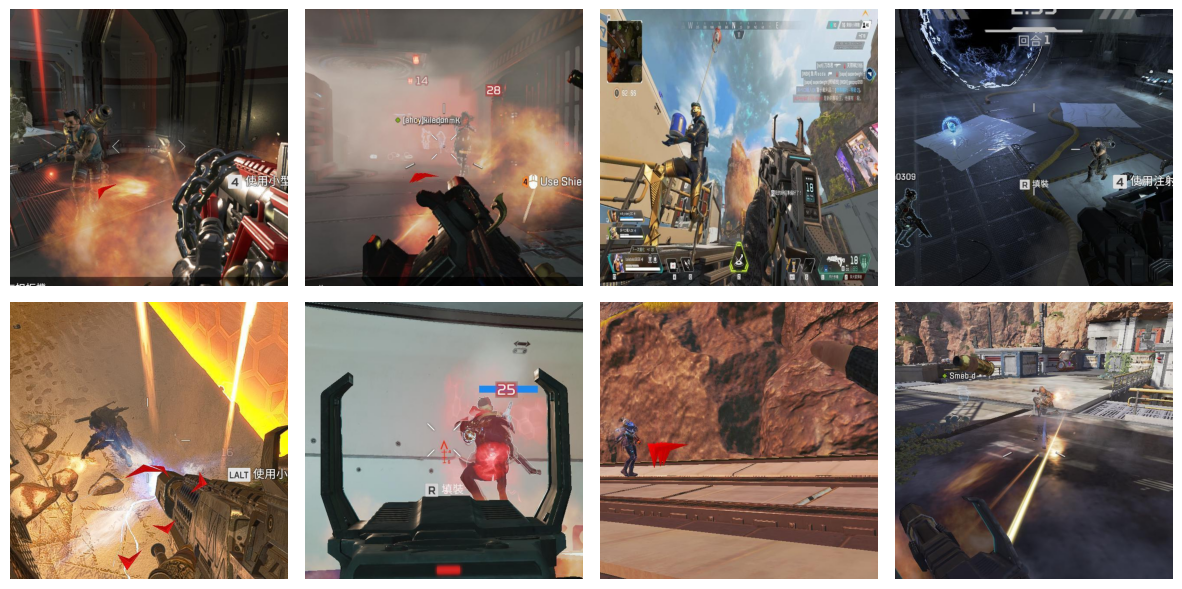

In [95]:
_ = visualization.plot_bounding_box_gallery(tensor_batch,
                                            value_range=(0, 255),
                                            rows=2,
                                            cols=4,
                                            y_pred=y_pred,
                                            scale=2,
                                            font_scale=0.7,
                                            bounding_box_format="xywh",
                                            class_mapping=class_mapping)

In [ ]:
dataset['train']